In [1]:
import os
import sys

root_folder = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(root_folder)

import numpy as np
import numpy.linalg as la
import numpy.matlib as matl
import scipy.io as io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget

from dynamics.orbit_dynamics import map_rtn_to_roe, roe_to_rtn_horizon, dynamics_roe_optimization
from optimization.rpod_scenario import sample_init_final, dock_param_maker, n_time_rpod, x_ell, y_ell, z_ell, period_ref, oe_0_ref, t_0, E_koz
from optimization.ocp import ocp_cvx, solve_scp, check_koz_constraint
import decision_transformer.manage as DT_manager
from dynamics.RpodEnv import RpodEnv
from decision_transformer.art_closed_loop import AutonomousRendezvousTransformerMPC, ConvexMPC, MyopicConvexMPC#, TwoPointsBoundaryValueProblemMPC, IterativeSequentialConvexProgrammingMPC


/home/davide.celestini/Transformer/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


cpu


In [2]:
# Initializations
scenario_test_dataset = True
transformer_model_name = 'checkpoint_rtn_ctgrtg_cl_7'
import_config = DT_manager.transformer_import_config(transformer_model_name)
state_representation = import_config['state_representation']
dataset_to_use = import_config['dataset_to_use']
mdp_constr = import_config['mdp_constr']
timestep_norm = import_config['timestep_norm']
transformer_ws = 'dyn'

# Scenario sampling 
if not scenario_test_dataset:
    # Transfer horizon (orbits)
    hrz = 2
    # Initial relative orbit
    da = 0 # [m]
    dlambda = 75 # [m]
    de = 1/E_koz.item((0,0))+10
    di = 1/E_koz.item((2,2))+10
    ph_de = np.pi/2 + 0*np.pi/180; # [m]
    ph_di = np.pi/2 + 0*np.pi/180; # [m]
    state_roe_0 = np.array([da, dlambda, de*np.cos(ph_de), de*np.sin(ph_de), di*np.cos(ph_di), di*np.sin(ph_di)]).reshape((6,))
    #relativeorbit_0 = roe_to_relativeorbit(state_roe_0, oe_0_ref)
    _, _, dock_param, cone_plotting_param = sample_init_final()
else:
    # Get the datasets and loaders from the torch data
    datasets, dataloaders = DT_manager.get_train_val_test_data(state_representation, dataset_to_use, mdp_constr, transformer_model_name, timestep_norm=timestep_norm)
    train_loader, eval_loader, test_loader = dataloaders


Loading data from root/dataset/torch/...Completed, DATA IS NOT SHUFFLED YET.



In [3]:

select_idx = True # set to True to manually select a test trajectory via its index (idx)
idx = 13912 # index of the test trajectory (e.g., dx = 654) 13912, 30768 !!!!!!!!
# Sample from test dataset
if select_idx:
    test_sample = test_loader.dataset.getix(idx)
else:
    ctgs0 = 0
    while ctgs0 < 50:
        test_sample = next(iter(test_loader))
        ctgs0 = test_sample[3][0,0,0].item()
if mdp_constr:
    states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, oe, dt, time_sec, horizons, ix = test_sample
else:
    states_i, actions_i, rtgs_i, goal_i, timesteps_i, attention_mask_i, oe, dt, time_sec, horizons, ix = test_sample
print('Sampled trajectory ' + str(ix) + ' from test_dataset.')
data_stats = test_loader.dataset.data_stats

Sampled trajectory [13912] from test_dataset.


In [4]:
# Convex solution
# Dynamics Matrices Precomputations
hrz = horizons.item()
if state_representation == 'roe':
    state_roe_0 = np.array((states_i[0, 0, :] * data_stats['states_std'][0]) + data_stats['states_mean'][0])
elif state_representation == 'rtn':
    state_rtn_0 = np.array((states_i[0, 0, :] * data_stats['states_std'][0]) + data_stats['states_mean'][0])
    state_roe_0 = map_rtn_to_roe(state_rtn_0, np.array(oe[0, :, 0]))
dock_param, cone_plotting_param = dock_param_maker(np.array((goal_i[0, 0, :] * data_stats['goal_std'][0]) + data_stats['goal_mean'][0]))
stm_hrz, cim_hrz, psi_hrz, oe_hrz, time_hrz, dt_hrz = dynamics_roe_optimization(oe_0_ref, t_0, hrz, n_time_rpod)


CVX cost: 0.22013117441290173
SCP cost: 0.2258892103823007
J vect [2.26905687e-01 2.26162165e-01 2.26021042e-01 2.25972504e-01
 2.25889847e-01 2.25889210e-01 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]
GPT size: 11.1M parameters
Using ART model ' checkpoint_rtn_ctgrtg_cl_7 ' with inference function DT_manage.torch_model_inference_dyn()
ART cost: 0.2285329
ART runtime: 1.1105806827545166
SCP cost: 0.2203226272237538
J vect [2.20326277e-01 2.20322681e-01 2.20322627e-01 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]


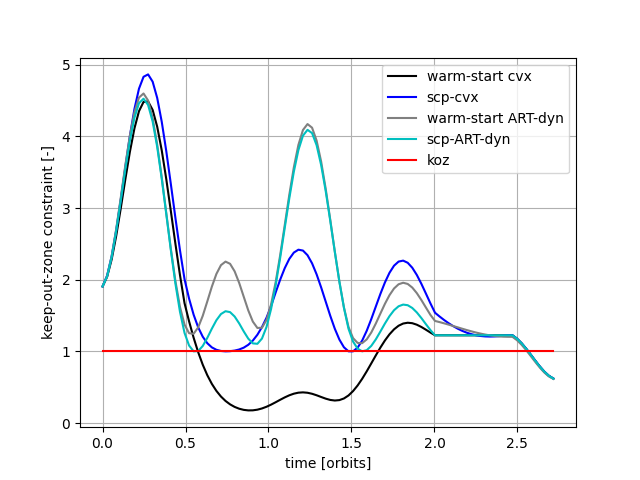

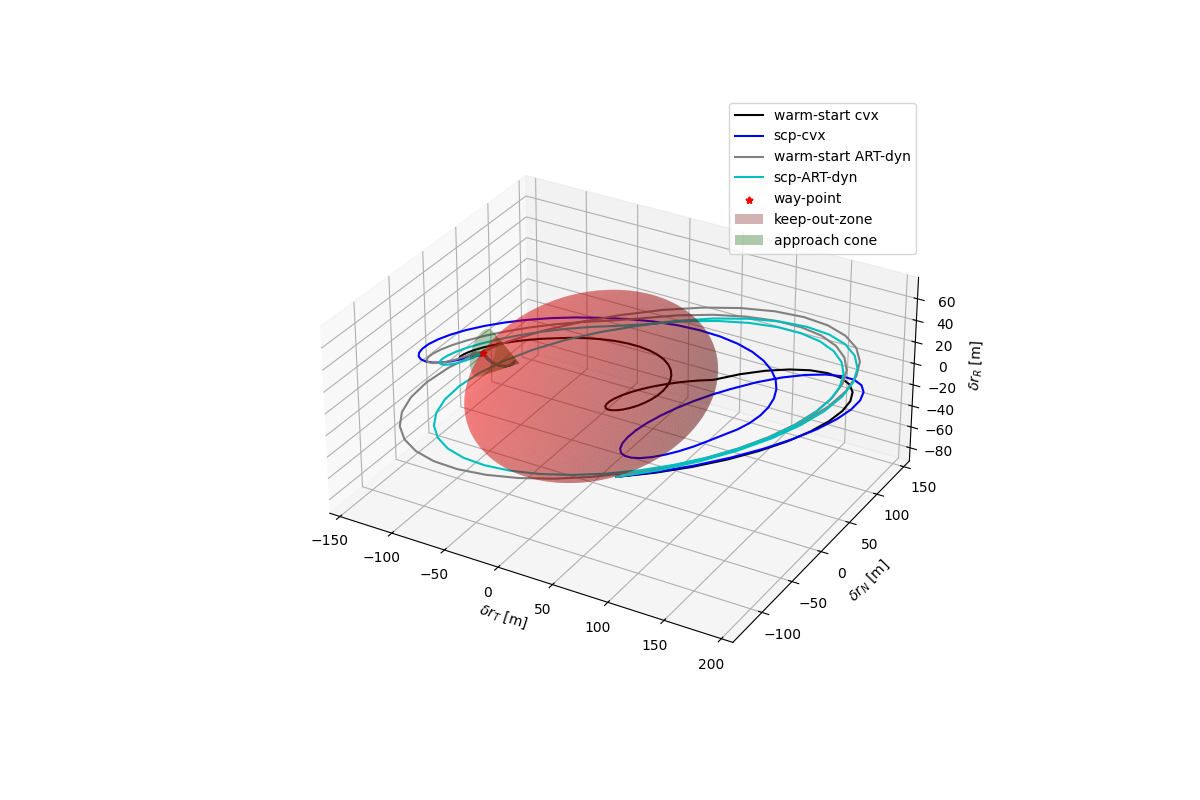

In [5]:
# Warmstarting and optimization
# Solve Convex Problem
states_roe_ws_cvx, actions_rtn_ws_cvx, feas_cvx = ocp_cvx(stm_hrz, cim_hrz, psi_hrz, state_roe_0, dock_param, n_time_rpod)
print('CVX cost:', la.norm(actions_rtn_ws_cvx, axis=0).sum())
states_rtn_ws_cvx = roe_to_rtn_horizon(states_roe_ws_cvx, oe_hrz, n_time_rpod)
constr_cvx, constr_viol_cvx= check_koz_constraint(states_rtn_ws_cvx, n_time_rpod)
# Solve SCP
states_roe_scp_cvx, actions_scp_cvx, feas_scp_cvx, iter_scp_cvx, J_vect_scp_cvx, runtime_scp_cvx = solve_scp(stm_hrz, cim_hrz, psi_hrz, state_roe_0, dock_param, states_roe_ws_cvx, n_time_rpod)
print('SCP cost:', la.norm(actions_scp_cvx, axis=0).sum())
print('J vect', J_vect_scp_cvx)
states_rtn_scp_cvx = roe_to_rtn_horizon(states_roe_scp_cvx, oe_hrz, n_time_rpod)
constr_scp_cvx, constr_viol_scp_cvx = check_koz_constraint(states_rtn_scp_cvx, n_time_rpod)


# Import the Transformer
model = DT_manager.get_DT_model(transformer_model_name, train_loader, eval_loader)
model.eval()
inference_func = getattr(DT_manager, 'torch_model_inference_'+transformer_ws)
print('Using ART model \'', transformer_model_name, '\' with inference function DT_manage.'+inference_func.__name__+'()')
rtg = - la.norm(actions_rtn_ws_cvx, axis=0).sum() if mdp_constr else None #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
DT_trajectory, runtime_DT = inference_func(model, test_loader, test_sample, stm_hrz, cim_hrz, psi_hrz, state_representation, rtg_perc=1., ctg_perc=0., rtg=rtg)
states_roe_ws_DT = DT_trajectory['roe_' + transformer_ws]# set warm start
states_rtn_ws_DT = DT_trajectory['rtn_' + transformer_ws]
actions_rtn_ws_DT = DT_trajectory['dv_' + transformer_ws]
print('ART cost:', la.norm(actions_rtn_ws_DT, axis=0).sum())
print('ART runtime:', runtime_DT)
constr_DT, constr_viol_DT = check_koz_constraint(states_rtn_ws_DT, n_time_rpod)

# Solve SCP
states_roe_scp_DT, actions_scp_DT, feas_scp_DT, iter_scp_DT, J_vect_scp_DT, runtime_scp_DT = solve_scp(stm_hrz, cim_hrz, psi_hrz, state_roe_0, dock_param, states_roe_ws_DT, n_time_rpod)
print('SCP cost:', la.norm(actions_scp_DT, axis=0).sum())
print('J vect', J_vect_scp_DT)
states_rtn_scp_DT = roe_to_rtn_horizon(states_roe_scp_DT, oe_hrz, n_time_rpod)
constr_scp_DT, constr_viol_scp_DT = check_koz_constraint(states_rtn_scp_DT, n_time_rpod)

# Plotting

# 3D position trajectory
ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')
p1 = ax.plot3D(states_rtn_ws_cvx[1,:], states_rtn_ws_cvx[2,:], states_rtn_ws_cvx[0,:], 'k', linewidth=1.5, label='warm-start cvx')
p2 = ax.plot3D(states_rtn_scp_cvx[1,:], states_rtn_scp_cvx[2,:], states_rtn_scp_cvx[0,:], 'b', linewidth=1.5, label='scp-cvx')
p3 = ax.plot3D(states_rtn_ws_DT[1,:], states_rtn_ws_DT[2,:], states_rtn_ws_DT[0,:], c=[0.5,0.5,0.5], linewidth=1.5, label='warm-start ART-' + transformer_ws)
p4 = ax.plot3D(states_rtn_scp_DT[1,:], states_rtn_scp_DT[2,:], states_rtn_scp_DT[0,:], 'c', linewidth=1.5, label='scp-ART-' + transformer_ws)

dock_wyp = dock_param['dock_wyp']
r_cone, t_cone, n_cone = cone_plotting_param['r_cone'], cone_plotting_param['t_cone'], cone_plotting_param['n_cone']
pwyp = ax.scatter(dock_wyp[1], dock_wyp[2], dock_wyp[0], color = 'r', marker = '*', linewidth=1.5, label='way-point')
pell = ax.plot_surface(y_ell, z_ell, x_ell, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3, label='keep-out-zone')
pell._facecolors2d = pell._facecolor3d
pell._edgecolors2d = pell._edgecolor3d
pcone = ax.plot_surface(t_cone, n_cone, r_cone, rstride=1, cstride=1, color='g', linewidth=0, alpha=0.3, label='approach cone')
pcone._facecolors2d = pcone._facecolor3d
pcone._edgecolors2d = pcone._edgecolor3d
ax.set_xlabel('$\delta r_T$ [m]', fontsize=10)
ax.set_ylabel('$\delta r_N$ [m]', fontsize=10)
ax.set_zlabel('$\delta r_R$ [m]', fontsize=10)
ax.grid(True)
ax.set_aspect('equal')
ax.legend(loc='best', fontsize=10)
plt.savefig(root_folder + '/optimization/saved_files/plots/pos_3d.png')

# Constraint satisfaction
plt.figure()
plt.plot(time_hrz/period_ref, constr_cvx, 'k', linewidth=1.5, label='warm-start cvx')
plt.plot(time_hrz/period_ref, constr_scp_cvx, 'b', linewidth=1.5, label='scp-cvx')
plt.plot(time_hrz/period_ref, constr_DT, c=[0.5,0.5,0.5], linewidth=1.5, label='warm-start ART-' + transformer_ws)
plt.plot(time_hrz/period_ref, constr_scp_DT, 'c', linewidth=1.5, label='scp-ART-' + transformer_ws)
plt.plot(time_hrz/period_ref, np.ones(n_time_rpod), 'r-', linewidth=1.5, label='koz')
plt.xlabel('time [orbits]', fontsize=10)
plt.ylabel('keep-out-zone constraint [-]', fontsize=10)
plt.grid(True)
plt.legend(loc='best', fontsize=10)
plt.savefig(root_folder + '/optimization/saved_files/plots/constr.png')

plt.show()

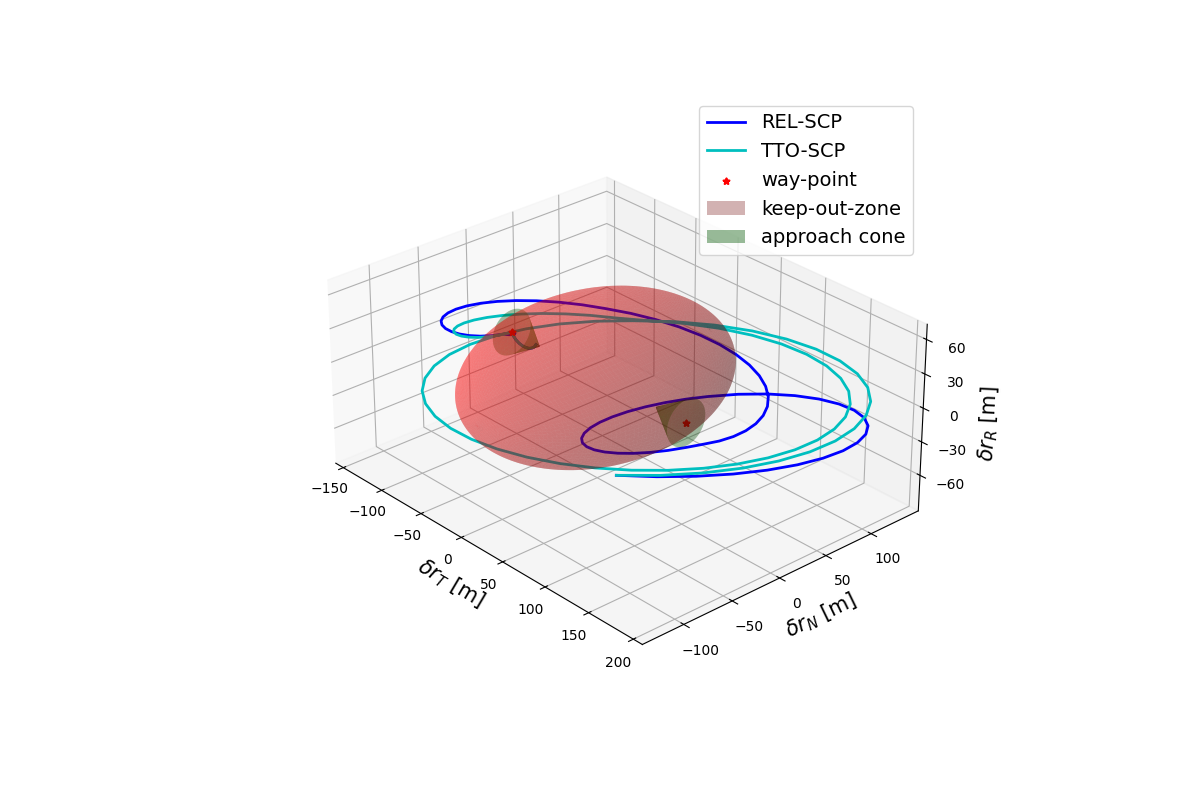

In [7]:
# 3D position trajectory
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
p2 = ax.plot3D(states_rtn_scp_cvx[1,:], states_rtn_scp_cvx[2,:], states_rtn_scp_cvx[0,:], 'b', linewidth=2, label='REL-SCP')
p4 = ax.plot3D(states_rtn_scp_DT[1,:], states_rtn_scp_DT[2,:], states_rtn_scp_DT[0,:], 'c', linewidth=2, label='TTO-SCP')

dock_wyp = dock_param['dock_wyp']
r_cone, t_cone, n_cone = cone_plotting_param['r_cone'], cone_plotting_param['t_cone'], cone_plotting_param['n_cone']
pwyp = ax.scatter(dock_wyp[1], dock_wyp[2], dock_wyp[0], color = 'r', marker = '*', linewidth=1.5, label='way-point')
pwyp2 = ax.scatter(-dock_wyp[1], dock_wyp[2], dock_wyp[0], color = 'r', marker = '*', linewidth=1.5)
pell = ax.plot_surface(y_ell, z_ell, x_ell, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3, label='keep-out-zone')
pell._facecolors2d = pell._facecolor3d
pell._edgecolors2d = pell._edgecolor3d
pcone = ax.plot_surface(t_cone, n_cone, r_cone, rstride=1, cstride=1, color='g', linewidth=0, alpha=0.4, label='approach cone')
pcone._facecolors2d = pcone._facecolor3d
pcone._edgecolors2d = pcone._edgecolor3d
pcone2 = ax.plot_surface(-t_cone, n_cone, r_cone, rstride=1, cstride=1, color='g', linewidth=0, alpha=0.4)
pcone2._facecolors2d = pcone._facecolor3d
pcone2._edgecolors2d = pcone._edgecolor3d
ax.set_xlabel('$\delta r_T$ [m]', fontsize=15)
ax.set_ylabel('$\delta r_N$ [m]', fontsize=15)
ax.set_zlabel('$\delta r_R$ [m]', fontsize=15)
ax.set_zticks([-60, -30, 0, 30, 60])
ax.grid(True)
ax.set_aspect('equal')
ax.view_init(elev=28, azim=-42)
ax.legend(loc='best', fontsize=14)
fig.savefig('rpod_scenario.svg')
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
#time_orb = np.arange(0,101)[None,:]
time_orb = (time_hrz/period_ref)
plot_orb_time = True
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time_orb, states_rtn_ws_cvx[j,:], 'k-', linewidth=1.5, label='CVX')
    plt.plot(time_orb, states_rtn_scp_cvx[j,:], 'b-', linewidth=1.5, label='scp-CVX')
    plt.plot(time_orb, states_rtn_ws_DT[j,:], 'grey', linewidth=1.5, label='ART')
    plt.plot(time_orb, states_rtn_scp_DT[j,:], 'c-', linewidth=1.5, label='scp-ART')
    if j == 0:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \delta r_r$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta r_t$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta r_n$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

# velocity vs time
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time_orb, states_rtn_ws_cvx[j+3,:], 'k-', linewidth=1.5, label='CVX')
    plt.plot(time_orb, states_rtn_scp_cvx[j+3,:], 'b-', linewidth=1.5, label='scp-CVX')
    plt.plot(time_orb, states_rtn_ws_DT[j+3,:], 'grey', linewidth=1.5, label='ART')
    plt.plot(time_orb, states_rtn_scp_DT[j+3,:], 'c-', linewidth=1.5, label='scp-ART')
    if j == 0:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \delta v_r$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta v_t$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta v_n$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()
###### DELTA-V

# components
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.stem(time_orb, actions_rtn_ws_cvx[j,:]*1000., linefmt='k', markerfmt='ko', label='CVX')
    plt.stem(time_orb, actions_scp_cvx[j,:]*1000, linefmt='b', markerfmt='bo', label='scp-CVX')
    plt.stem(time_orb, actions_rtn_ws_DT[j,:]*1000., linefmt='grey', markerfmt='o', label='ART')
    plt.stem(time_orb, actions_scp_DT[j,:]*1000, linefmt='c', markerfmt='o', label='scp-ART')
    if j == 0:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \Delta \delta v$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
rpod_env_art = RpodEnv()
rpod_env_cvx = RpodEnv()
traj_sample = (hrz, state_roe_0, dock_param)
rpod_env_art.reset('det',traj_sample)
rpod_env_cvx.reset('det',traj_sample)
art_cl = AutonomousRendezvousTransformerMPC(model,test_loader,10,transformer_mode='dyn',scp_mode='soft')
#oracle_cl = ConvexMPC(100,scp_mode='soft')
cvx_cl = MyopicConvexMPC(10,scp_mode='soft')
'''art_cl = IterativeSequentialConvexProgrammingMPC('art', model, test_loader,scp_mode='soft')
cvx_cl = IterativeSequentialConvexProgrammingMPC('cvx',scp_mode='soft')
cvx_cl = MyopicConvexMPC(100,scp_mode='soft')
cvx_cl = TwoPointsBoundaryValueProblemMPC(100,scp_mode='soft')'''

In [ ]:
time_ARTMPC = np.empty((100,))#np.empty((actions_rtn_ws_DT.shape[1],))
time_CVXMPC = np.empty((100,))#np.empty((actions_rtn_ws_DT.shape[1],))
time_myo_CVXMPC = np.empty((100,))#np.empty((actions_rtn_ws_DT.shape[1],))
flag = 'all'
import time
for i in np.arange(100):#actions_rtn_ws_DT.shape[1]):
    print(i)
    if flag == 'art' or flag == 'all':
        # ART-ws
        current_obs_art = rpod_env_art.get_observation()
        real_obs = {
            'state_roe' : rpod_env_art.state_roe[:,-1].copy(),
            'state_rtn' : rpod_env_art.state_rtn[:,-1].copy(),
            'oe' : rpod_env_art.oe[:,-1].copy()
        }
        tic = time.time()
        if mdp_constr:
            ART_traj, stm, cim, psi = art_cl.warmstart(current_obs_art, rpod_env_art, rtg0=rtg, ctg0=0, return_dynamics=True)
        else:
            ART_traj, stm, cim, psi = art_cl.warmstart(current_obs_art, rpod_env_art, rtgs_i=rtgs_i, return_dynamics=True)
        ARTMPC_traj, ARTMPC_scp_dict = art_cl.solve_scp(current_obs_art, rpod_env_art, stm, cim, psi, ART_traj['state_roe'], ART_traj['dv_rtn'])
        time_ARTMPC[i] = time.time() - tic
        '''print('oracle')
        oracle_traj, stm, cim, psi = oracle_cl.warmstart(current_obs_art, rpod_env_art, return_dynamics=True)
        oracleMPC_traj, oracleMPC_scp_dict = oracle_cl.solve_scp(current_obs_art, rpod_env_art, stm, cim, psi, oracle_traj['state_roe'], oracle_traj['dv_rtn'])'''

        #if i < 80:
        rpod_env_art.load_prediction(ART_traj, ARTMPC_traj)
        _ = rpod_env_art.step(ARTMPC_traj['dv_rtn'][:,0],'rtn')
        '''else:
            rpod_env_art.load_prediction(oracle_traj, oracleMPC_traj)
            _,_ = rpod_env_art.step(oracleMPC_traj['dv_rtn'][:,0],'rtn')'''
    
    if flag == 'cvx' or flag == 'all':
        #CVX-ws
        current_obs_cvx = rpod_env_cvx.get_observation()
        real_obs = {
            'state_roe' : rpod_env_cvx.state_roe[:,-1].copy(),
            'state_rtn' : rpod_env_cvx.state_rtn[:,-1].copy(),
            'oe' : rpod_env_cvx.oe[:,-1].copy()
        }
        tic = time.time()
        CVX_traj, stm, cim, psi = cvx_cl.warmstart(current_obs_cvx, rpod_env_cvx, return_dynamics=True)
        CVXMPC_traj, CVXMPC_scp_dict = cvx_cl.solve_scp(current_obs_cvx, rpod_env_cvx, stm, cim, psi, CVX_traj['state_roe'], CVX_traj['dv_rtn'])
        time_CVXMPC[i] = time.time() - tic
        rpod_env_cvx.load_prediction(CVX_traj, CVXMPC_traj)
        _ = rpod_env_cvx.step(CVXMPC_traj['dv_rtn'][:,0],'rtn')


In [ ]:
from ipywidgets import interact
maneuver_dict_art = {
    'state_rtn_ART' : states_rtn_ws_DT,
    'state_rtn_scpART' : states_rtn_scp_DT,
    'time_orb' : time_orb
}
fig_art, ax_art = rpod_env_art.plot(maneuver=maneuver_dict_art, mpc_label='ART')
#plt.close()
maneuver_dict_cvx = {
    'state_rtn_ART' : states_rtn_ws_cvx,
    'state_rtn_scpART' : states_rtn_scp_cvx,
    'time_orb' : time_orb
}
fig_cvx, ax_cvx = rpod_env_cvx.plot(maneuver=maneuver_dict_cvx, mpc_label='CVX')
#plt.close()

@interact(k=(0, 101))
def plot(k=0):
    if flag == 'art' or flag == 'all':
        history_dict_art = {
            'state_rtn' : rpod_env_art.state_rtn[:,:k+1],
            'time_orb' : rpod_env_art.time[:k+1]/rpod_env_art.period_ref
        }
        rpod_env_art.plot(ax=ax_art, plan=(rpod_env_art.pred_history[k] if k < rpod_env_art.timestep else None), history=history_dict_art)
        fig_art.canvas.draw()

    if flag == 'cvx' or flag == 'all':
        history_dict_cvx = {
            'state_rtn' : rpod_env_cvx.state_rtn[:,:k+1],
            'time_orb' : rpod_env_cvx.time[:k+1]/rpod_env_cvx.period_ref
        }
        rpod_env_cvx.plot(ax=ax_cvx, plan=(rpod_env_cvx.pred_history[k] if k < rpod_env_cvx.timestep else None), history=history_dict_cvx)
        fig_cvx.canvas.draw()

    #return fig_art

In [ ]:
from ipywidgets import interact
maneuver_dict_art = {
    'state_rtn_ART' : states_rtn_ws_DT,
    'state_rtn_scpART' : states_rtn_scp_DT,
    'time_orb' : time_orb
}
fig_art, ax_art = rpod_env_art.plot3D(maneuver=maneuver_dict_art, mpc_label='ART')
#plt.close()
maneuver_dict_cvx = {
    'state_rtn_ART' : states_rtn_ws_cvx,
    'state_rtn_scpART' : states_rtn_scp_cvx,
    'time_orb' : time_orb
}
fig_cvx, ax_cvx = rpod_env_cvx.plot3D(maneuver=maneuver_dict_cvx, mpc_label='CVX')
#plt.close()

flag = 'all'
@interact(k=(0, 101))
def plot(k=0):
    if flag == 'art' or flag == 'all':
        history_dict_art = {
            'state_rtn' : rpod_env_art.state_rtn[:,:k+1],
            'time_orb' : rpod_env_art.time[:k+1]/rpod_env_art.period_ref
        }
        rpod_env_art.plot3D(ax=ax_art, plan=(rpod_env_art.pred_history[k] if k < rpod_env_art.timestep else None), history=history_dict_art)
        fig_art.canvas.draw()

    if flag == 'cvx' or flag == 'all':
        history_dict_cvx = {
            'state_rtn' : rpod_env_cvx.state_rtn[:,:k+1],
            'time_orb' : rpod_env_cvx.time[:k+1]/rpod_env_cvx.period_ref
        }
        rpod_env_cvx.plot3D(ax=ax_cvx, plan=(rpod_env_cvx.pred_history[k] if k < rpod_env_cvx.timestep else None), history=history_dict_cvx)
        ax_cvx.set_aspect('equal')
        fig_cvx.canvas.draw()

In [ ]:
# Timeseries to compare
time0 = time_orb#ART_traj['time_orb'][0]#
states0 = states_rtn_ws_DT#states_rtn_scp_cvx#ARTMPC_state_rtn#
time1 = time_orb#ART_traj['time_orb'][0]#
states1 = states_rtn_scp_DT#states_rtn_scp_cvx#ARTMPC_state_rtn#
time2 = rpod_env_art.time/rpod_env_art.period_ref#np.empty(0)#np.arange(rpod_env.timestep-1,100)#ART_traj['time_orb']#
states2 = rpod_env_art.state_rtn#np.empty((6,0))#ARTMPC_traj['state_rtn']#ART_traj['state_rtn']#
time3 = rpod_env_cvx.time/rpod_env_cvx.period_ref#np.empty(0)#np.arange(rpod_env.timestep-1,100)#ART_traj['time_orb']#
states3 = rpod_env_cvx.state_rtn#np.empty((6,0))#ART_traj['state_rtn']#ARTMPC_traj['state_rtn']#

plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time0, states0[j,:], 'k-', linewidth=1.5, label='ART')
    plt.plot(time1, states1[j,:], 'b-', linewidth=1.5, label='scp-ART')
    plt.plot(time2, states2[j,:], 'g--', linewidth=1.5, label='ARTMPC')
    plt.plot(time3, states3[j,:], 'c--', linewidth=1.5, label='CVXMPC')
    if j == 0:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \delta r_r$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta r_t$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta r_n$ [m]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

# velocity vs time
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.plot(time0, states0[j+3,:], 'k-', linewidth=1.5, label='ART')
    plt.plot(time1, states1[j+3,:], 'b-', linewidth=1.5, label='scp-ART')
    plt.plot(time2, states2[j+3,:], 'g--', linewidth=1.5, label='ARTMPC')
    plt.plot(time3, states3[j+3,:], 'c--', linewidth=1.5, label='CVXMPC')
    if j == 0:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \delta v_r$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta v_t$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$\delta v_n$ [m/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
###### DELTA-V
# Timeseries to compare
time0 = time_orb#ART_traj['time_orb'][0]#
action0 = actions_rtn_ws_DT#ARTMPC_dv_rtn#
time1 = time_orb#ART_traj['time_orb'][0]#
action1 = actions_scp_DT#ARTMPC_dv_rtn#
time2 = rpod_env_art.time[:-1]/rpod_env_art.period_ref#time_orb[0][:-1]#ART_traj['time_orb']#
action2 = rpod_env_art.dv_rtn#ART_traj['dv_rtn']#
time3 = rpod_env_cvx.time[:-1]/rpod_env_cvx.period_ref#time_orb[0][:-1]#ART_traj['time_orb']#
action3 = rpod_env_cvx.dv_rtn#ART_traj['dv_rtn']#

# components
plt.figure(figsize=(20,5))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.stem(time0, action0[j,:]*1000., linefmt='k', markerfmt='ko', label='ART')
    plt.stem(time1, action1[j,:]*1000., linefmt='b', markerfmt='bo', label='scp-ART')
    plt.stem(time2, action2[j,:]*1000, linefmt='g', markerfmt='g^', label='ARTMPC')
    plt.stem(time3, action3[j,:]*1000, linefmt='c', markerfmt='c*', label='CVXMPC')
    
    if j == 0:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_r$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 1:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_t$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
    elif j == 2:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=10)
        plt.ylabel('$ \Delta \delta v_n$ [mm/s]', fontsize=10)
        plt.grid(True)
        plt.legend(loc='best', fontsize=10)
plt.show()

In [ ]:
constr_ARTMPC, constr_viol_ARTMPC = check_koz_constraint(rpod_env_art.state_rtn, rpod_env_art.timestep)
constr_CVXMPC, constr_viol_CVXMPC = check_koz_constraint(rpod_env_cvx.state_rtn, rpod_env_cvx.timestep)

# Constraint satisfaction
plt.figure()
plt.plot(time_hrz/period_ref, constr_DT, 'k', linewidth=1.5, label='warm-start ART-' + transformer_ws)
plt.plot(time_hrz/period_ref, constr_scp_DT, 'b', linewidth=1.5, label='scp-ART-' + transformer_ws)
plt.plot(time_hrz/period_ref, constr_ARTMPC, 'g--', linewidth=1.5, label='ART-MPC')
plt.plot(time_hrz/period_ref, constr_CVXMPC, 'c--', linewidth=1.5, label='CVX-MPC')
plt.plot(time_hrz/period_ref, np.ones(n_time_rpod), 'r-', linewidth=1.5, label='koz')
plt.xlabel('time [orbits]', fontsize=10)
plt.ylabel('keep-out-zone constraint [-]', fontsize=10)
plt.grid(True)
plt.legend(loc='best', fontsize=10)

In [ ]:
print('ART-MPC cost', np.sum(np.linalg.norm(rpod_env_art.dv_rtn,axis=0)))
print('CVX-MPC cost', np.sum(np.linalg.norm(rpod_env_cvx.dv_rtn,axis=0)))
print('SCP open loop cost history', J_vect_scp_DT)

In [ ]:
plt.figure()
plt.plot(time_ARTMPC, label='ARTMPC')
plt.plot(time_CVXMPC, label='CVXMPC')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
results = np.load('saved_files/closed_loop_analysis_checkpoint_rtn_ctgrtg_v02.npz')
results.allow_pickle = True
cost = results['cost'].item()
indexes = results['indexes']
count_eff = results['counter_eff']


In [ ]:
# Computes ctgs
ctgs0 = -np.ones((len(indexes),))
for i,idx in enumerate(indexes):
    test_sample = test_loader.dataset.getix(int(idx))
    states_i, actions_i, rtgs_i, ctgs_i, timesteps_i, attention_mask_i, oe, dt, time_sec, horizons, ix = test_sample
    data_stats = test_loader.dataset.data_stats
    hrz = horizons.item()
    state_rtn_0 = np.array((states_i[0, 0, :] * data_stats['states_std'][0]) + data_stats['states_mean'][0])
    state_roe_0 = map_rtn_to_roe(state_rtn_0, np.array(oe[0, :, 0]))
    stm_hrz, cim_hrz, psi_hrz, oe_hrz, time_hrz, dt_hrz = dynamics_roe_optimization(oe_0_ref, t_0, hrz, n_time_rpod)

    # Warmstarting and optimization
    # Solve Convex Problem
    states_roe_ws_cvx, actions_rtn_ws_cvx, feas_cvx = ocp_cvx(stm_hrz, cim_hrz, psi_hrz, state_roe_0, n_time_rpod)
    states_rtn_ws_cvx = roe_to_rtn_horizon(states_roe_ws_cvx, oe_hrz, n_time_rpod)
    _, constr_viol_cvx= check_koz_constraint(states_rtn_ws_cvx, n_time_rpod)
    ctgs0[i] = np.sum(constr_viol_cvx)

In [ ]:
# Ordered results for ctgs0
ctgs0_set = set(ctgs0)
mean_costs = {
    'cvx' : np.zeros((len(ctgs0_set,))),
    'cvx_scp' : np.zeros((len(ctgs0_set,))),
    'cvx_mpc' : np.zeros((len(ctgs0_set,))),
    'art' : np.zeros((len(ctgs0_set,))),
    'art_scp' : np.zeros((len(ctgs0_set,))),
    'art_mpc' : np.zeros((len(ctgs0_set,)))
}
ctgs0_count = np.zeros((len(ctgs0_set,)))

for i,ctg in enumerate(ctgs0_set):
    idx_ctg = ctgs0 == ctg
    mean_costs['cvx'][i] = cost['cvx'][idx_ctg].mean()
    mean_costs['cvx_scp'][i] = cost['cvx_scp'][idx_ctg].mean()
    mean_costs['cvx_mpc'][i] = cost['cvx_mpc'][idx_ctg].mean()
    mean_costs['art'][i] = cost['art'][idx_ctg].mean()
    mean_costs['art_scp'][i] = cost['art_scp'][idx_ctg].mean()
    mean_costs['art_mpc'][i] = cost['art_mpc'][idx_ctg].mean()
    ctgs0_count[i] = idx_ctg.sum()


In [ ]:
indexes[ctgs0==30] # array([26123., 18622., 20254., 24555., 32460., 26993.])

In [ ]:
cost['cvx_mpc'][indexes==26993], cost['art_mpc'][indexes==26993]

In [ ]:
ctgs0_list = list(ctgs0_set)
fig, ax1 = plt.subplots()
ax1.plot(ctgs0_list,(mean_costs['cvx_scp'] - mean_costs['cvx'])*1000,label='cvx_scp')
ax1.plot(ctgs0_list,(mean_costs['cvx_mpc'] - mean_costs['cvx'])*1000,label='cvx_mpc')
'''ax1.plot(ctgs0_list,(mean_costs['art'] - mean_costs['cvx'])*1000,c='grey',label='art')'''
ax1.plot(ctgs0_list,(mean_costs['art_scp'] - mean_costs['cvx'])*1000,label='art_scp')
ax1.plot(ctgs0_list,(mean_costs['art_mpc'] - mean_costs['cvx'])*1000,label='art_mpc')
ax1.grid(True)
ax1.legend(loc='best')
ax1.set_xlabel('$ctgs_0$')
ax1.set_ylabel('$J - J_{cvx}$')
ax2 = ax1.twinx()
ax2.plot(ctgs0_list,ctgs0_count,c='grey')
ax2.set_ylabel('count')

plt.show()